In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/README.dataset.txt
/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid/dry/dry_3b16046d1c224bcac3b2_jpg.rf.7a0306e201e8e93ad4bba8ba27dfd78e.jpg
/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid/dry/dry_07364d92affd8d28353e_jpg.rf.9cb9c6e2911a02be6924c7ca0d0aa266.jpg
/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid/dry/dry_1a4996793e7fdccadd63_jpg.rf.b1a4fe04e1620d964bbb3a617ab8eb9c.jpg
/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid/dry/dry_a39f6681bf3115c36e4c_jpg.rf.4fca98dcd315cb393f762e8a1f0bc44a.jpg
/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid/dry/dry_a80e3fa56f1b08178317_jpg.rf.9b38e6ca17a9568243b8c2a7f4a7952e.jpg
/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid/dry/dry_3f0225ae0ea8c5a9b7bb_jpg.rf.268f2133c6681fb2564a1d38a3c61dc5.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [4]:
train_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train")
val_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid")
test_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test")

In [5]:
train_df = pd.concat([train_df, val_df, test_df])

In [6]:
train_df

,images,labels
0,/kaggle/input/oily-dry-and-normal-skin-types-d...,0
1,/kaggle/input/oily-dry-and-normal-skin-types-d...,0
2,/kaggle/input/oily-dry-and-normal-skin-types-d...,0
3,/kaggle/input/oily-dry-and-normal-skin-types-d...,0
4,/kaggle/input/oily-dry-and-normal-skin-types-d...,0
...,...,...
129,/kaggle/input/oily-dry-and-normal-skin-types-d...,2
130,/kaggle/input/oily-dry-and-normal-skin-types-d...,2
131,/kaggle/input/oily-dry-and-normal-skin-types-d...,2
132,/kaggle/input/oily-dry-and-normal-skin-types-d...,2


In [7]:
image_path = train_df['images'].iloc[0]
image = Image.open(image_path)
image_dimensions = image.size
image_dimensions

(640, 640)

In [8]:
def check_image_resolutions(df):
    # List to store image sizes
    image_sizes = []
    
    # Iterate over the images
    for index, row in df.iterrows():
        img = Image.open(row['images'])
        image_sizes.append(img.size)  # Append (width, height)
    
    # Convert to a DataFrame for easier analysis
    size_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
    
    # Print unique sizes and their counts
    size_counts = size_df.value_counts().reset_index(name='Count')
    print(size_counts)
    
    # Check if all images are of the same size
    unique_sizes = size_df.drop_duplicates()
    
    if len(unique_sizes) == 1:
        print('All images have the same resolution:', unique_sizes.iloc[0].to_dict())
    else:
        print('Images have varying resolutions.')
    
    return size_counts

# Check image resolutions
image_resolutions = check_image_resolutions(train_df)

   Width  Height  Count
0    640     640   3152
All images have the same resolution: {'Width': 640, 'Height': 640}


In [9]:
images_dim = []
for i in range(len(train_df)):
    image_path = train_df['images'].iloc[i]
    image = Image.open(image_path)
    image_dimensions = image.size
    images_dim.append(image_dimensions)

set(images_dim)

{(640, 640)}

In [10]:
train_df.groupby('labels').describe()

images                                                               
        count unique                                                top freq
labels                                                                      
0         758    758  /kaggle/input/oily-dry-and-normal-skin-types-d...    1
1        1274   1274  /kaggle/input/oily-dry-and-normal-skin-types-d...    1
2        1120   1120  /kaggle/input/oily-dry-and-normal-skin-types-d...    1

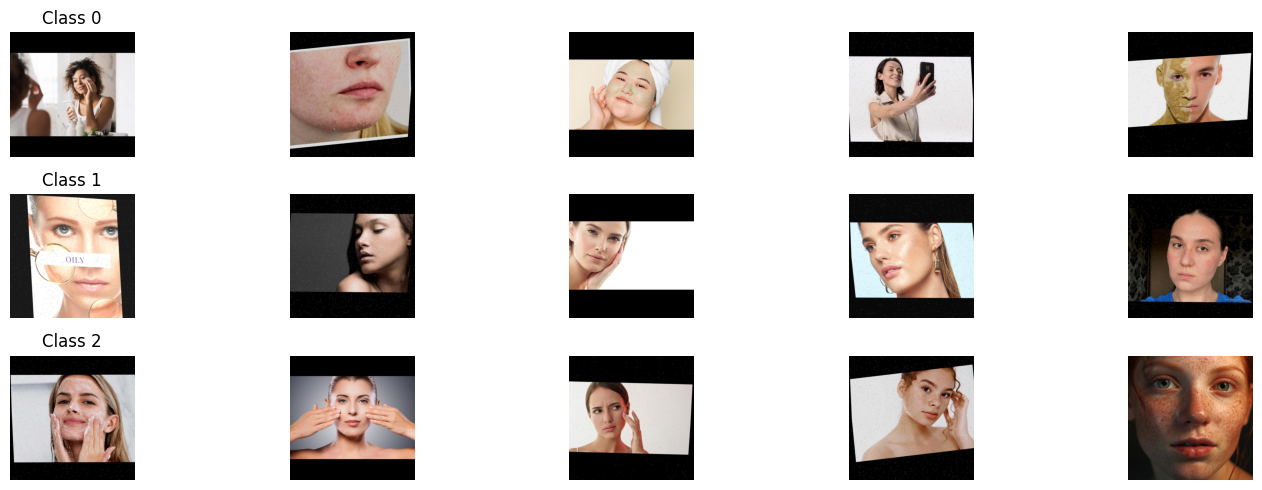

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

def plot_example_images(df, num_classes=3, num_images_per_class=5):
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, 5))
    
    for class_id in range(num_classes):
        class_images = df[df['labels'] == class_id].sample(num_images_per_class)
        for i, (index, row) in enumerate(class_images.iterrows()):
            img = Image.open(row['images'])
            axes[class_id, i].imshow(img)
            axes[class_id, i].axis('off')
            if i == 0:
                axes[class_id, i].set_title(f'Class {class_id}')
    
    plt.tight_layout()
    plt.show()

plot_example_images(train_df)


In [12]:
# def compute_mean_pixel_values(df):
#     mean_pixel_values = {}
    
#     unique_labels = df['labels'].unique()
    
#     for label in unique_labels:
#         label_df = df[df['labels'] == label]
#         label_pixel_means = []
        
#         for index, row in label_df.iterrows():
#             img = Image.open(row['images'])
#             img_array = np.array(img)
#             mean_pixel_value = img_array.mean()
#             label_pixel_means.append(mean_pixel_value)
#         mean_pixel_values[label] = np.mean(label_pixel_means)
    
#     return mean_pixel_values


In [13]:
def compute_mean_image(df, label):
    label_df = df[df['labels'] == label]
    images = []
    
    for index, row in label_df.iterrows():
        img = Image.open(row['images'])
        img_array = np.array(img, dtype=np.float32)
        images.append(img_array)
    
    stacked_images = np.stack(images)
    mean_image = np.mean(stacked_images, axis=0)
    
    return mean_image.astype(np.uint8)

def plot_mean_images(mean_images, labels):
    num_labels = len(labels)
    fig, axes = plt.subplots(1, num_labels, figsize=(15, 5))
    
    for i, label in enumerate(labels):
        axes[i].imshow(mean_images[label])
        axes[i].set_title(f'Label {label}')
        axes[i].axis('off')
    
    plt.show()

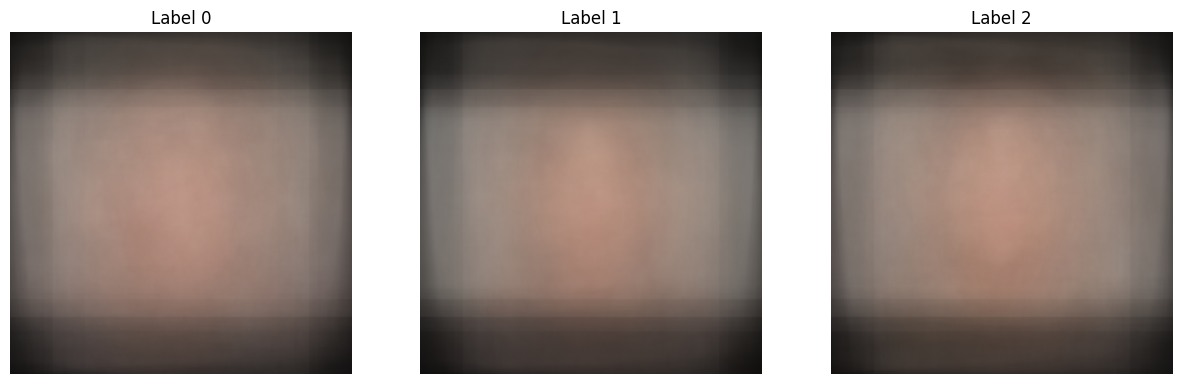

In [14]:
unique_labels = train_df['labels'].unique()
mean_images = {label: compute_mean_image(train_df, label) for label in unique_labels}
plot_mean_images(mean_images, unique_labels)

In [15]:
def describe_dataset(df):
    num_classes = df['labels'].nunique()
    num_images = len(df)
    print(f'Number of classes: {num_classes}')
    print(f'Number of images: {num_images}')

    # Check if image sizes are uniform
    image_sizes = []
    for index, row in df.iterrows():
        img = Image.open(row['images'])
        image_sizes.append(img.size)
    
    unique_sizes = set(image_sizes)
    print(f'Unique image sizes: {unique_sizes}')
    
    if len(unique_sizes) > 1:
        print('Images are not of uniform size and may need to be resized or cropped.')
    else:
        print('Images are of uniform size.')
    
    # Plot example images
    plot_example_images(df, num_classes=3, num_images_per_class=5)

Number of classes: 3
Number of images: 3152
Unique image sizes: {(640, 640)}
Images are of uniform size.


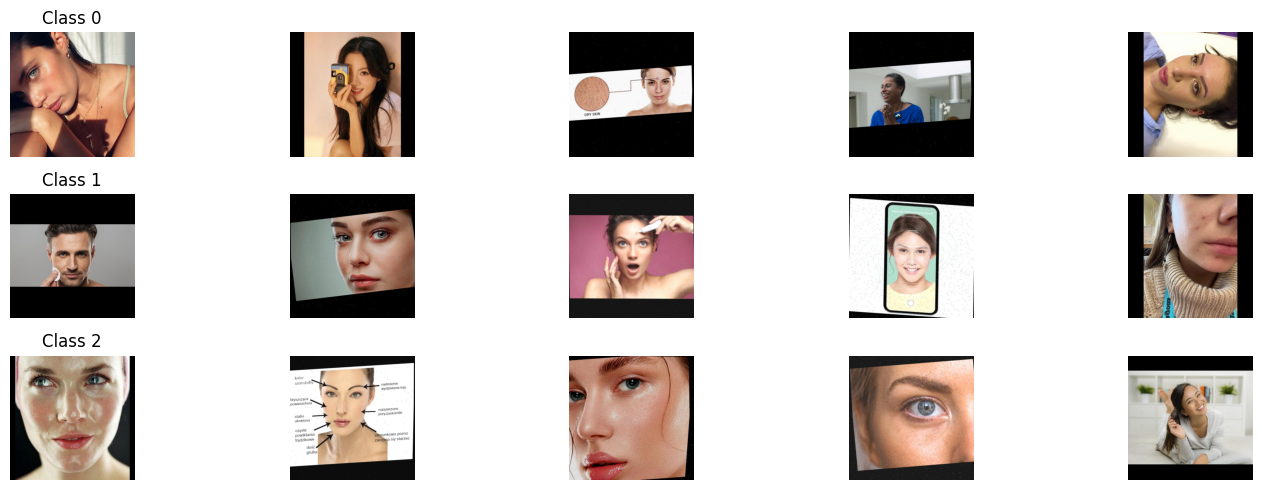

In [16]:
describe_dataset(train_df)